In [139]:
import sys
import os
sys.path.append('..')
print(sys.path)
from tools.fetching_description_from_huggingface import fetching_description_from_huggingface
from typing import TypedDict, Annotated, List
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage
from langchain.agents import create_tool_calling_agent, AgentExecutor
from pydantic import BaseModel, Field
from langchain.tools import Tool
from firecrawl import FirecrawlApp
from langchain_core.output_parsers import PydanticOutputParser
import pandas as pd
import pprint
from dotenv import load_dotenv
from enum import Enum

['/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/mnt/g/Ai agents course/LangGraph/venv/lib/python3.12/site-packages', '..', '..', '..', '..', '..', '..', '..']


In [140]:
load_dotenv(override=True)

python-dotenv could not parse statement starting at line 3


True

In [141]:
OPENAI_API_KEY='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'
BASE_URL='https://api.groq.com/openai/v1'
MODEL="meta-llama/llama-4-scout-17b-16e-instruct"

In [142]:
df_task = pd.read_csv("../Test/data/ISE - AutoCode Challenge 2 Public - Public task.csv")
df_model = pd.read_csv("../Test/data/ISE - AutoCode Challenge 2 Public - Model zoo.csv")

In [143]:
df_task

,STT,Task,Validation data
0,1,"""Bối cảnh của vấn đề:\r\nNhận dạng chữ viết ta...",Link
1,2,Bối cảnh của vấn đề:\r\nTrong thời đại thông t...,Link
2,3,Bối cảnh của vấn đề:\r\nĐây là một nhiệm vụ hồ...,Link
3,4,Bối cảnh của vấn đề:\r\nĐiều quan trọng là các...,Link
4,5,Bối cảnh của vấn đề:\r\nTrong nhiều ứng dụng t...,Link
5,6,🐾 Story: Alice’s Magical Pet Photo Box\r\nAlic...,Link


In [144]:
def format_model_list(df):
    model_strings = []
    for i, row in df.iterrows():
        desc = str(row[1]).replace("{", "{{").replace("}", "}}")
        url = str(row[2])
        model_strings.append(f"{i + 1} - {desc} [More info]({url})")
    return "\n".join(model_strings)


# Tools

In [145]:
def web_scraper(url: str) -> str:
    """Get more details about the model using the model url"""
    # scraper = FirecrawlApp(api_key=os.getenv("FIRECRAWL_API_KEY"))
    # scrape_status = scraper.scrape_url(
    #     url,
    #     formats=['markdown']
    # )
    # return scrape_status.markdown
    result = fetching_description_from_huggingface(url)
    return result

In [146]:
class WebScraperParameters(BaseModel):
    url: str

In [147]:
res = web_scraper('https://huggingface.co/thanhtlx/image_classification_01')

In [148]:
tools = [
    Tool(
        name="web_scrapper",
        func=web_scraper,
        description="Use to get more detail about the model",
        args_schema=WebScraperParameters
    )
]

# Output Format

In [149]:
class Error(Enum):
    MODEL_TOOL_ERROR = "model_tool_error"

In [150]:
class Tasks(BaseModel):
    subtask_one: str = Field(
        ...,
        description="Detailed description of task 1"
    )
    subtask_two: str = Field(
        ...,
        description="Detailed description of task 2"
    )
    subtask_three: str = Field(
        ...,
        description="Detailed description of task 3"
    )
    subtask_four: str = Field(
        ...,
        description="Detailed description of task 4"
    )

In [151]:
class ModelInfo(BaseModel):
    model: str = Field(..., description="Model name and description")
    url: str = Field(..., description="URL to the model")

class ModelSelection(BaseModel):
    models: List[ModelInfo] = Field(..., description="List of available models with name and URL")

In [152]:
class ModelingOutput(BaseModel):
    model_description: str = Field(
        ...,
        description="The detailed description of the model."
    )
    model_input_format: str = Field(
        ...,
        description="Model's detailed input format"
    )
    model_output_format: str = Field(
        ...,
        description="Model's detailed output format"
    )
    model_requirements: str = Field(
        ...,
        description="Requirement libraries need to install to use the model."
    )
    model_sample_code: str = Field(
        ...,
        description="Example code to use the model"
    )

class ModelList(BaseModel):
    models: List[ModelingOutput] = Field(
        ...,
        description="List of suitable model for given task"
    )

# Agent

In [153]:
llm = ChatOpenAI( 
    base_url=BASE_URL,
    model=MODEL,
    api_key=OPENAI_API_KEY,
    temperature=0.3
)

In [154]:
class AgentState(TypedDict):
    task: HumanMessage | None
    data: str | None
    messages: Annotated[List[BaseMessage], add_messages]
    subtasks: Tasks
    models: ModelSelection
    model_description: str
    model_detailed_list: ModelList
    output_classes: str | None
    code: str | None
    error: str | None

## Task Formulation Agent

In [155]:
def classify_agent(state: AgentState) -> AgentState:
    structured_llm = llm.with_structured_output(Tasks)
    system_prompt = """
        You are an expert in task formulation. Given a machine learning task, you will
        help divide the task into these subtasks:
        - Subtask1: for identifying task description and classify the problem type.
        - Subtask2: for identifying the problem requirements as described in the "Yêu cầu cụ thể cần đạt được" (or other equivalent) section, including: problem requirements, expected input and expected output.
        - Subtask3: for identifying the input format of the problem, as being described in the "Định dạng dữ liệu đầu vào cho bài toán tổng thể" (or other equivalent) section.
        - Subtask4: for identifying the output format of the problem with the given classes, as being described in the "Định dạng kết quả đầu ra mong muốn cho bài toán tổng thể" (or other equivalent) section.

        You **MUST** follow these guidelines:
        - Do not mistake the output classes with the one described in the problem requirements. The output classes **MUST** contain the classes described in the "Định dạng kết quả đầu ra mong muốn cho bài toán tổng thể" section.
        - Describe the subtasks as specific as possible.
        """
    messages = [SystemMessage(content=system_prompt)]
    messages.append(state['task'])
    result = structured_llm.invoke(messages)
    state['subtasks'] = result
    return state

### Testing task formulation agent

In [156]:
task = df_task["Task"][5]

In [157]:
state = {
    "task": HumanMessage(content=task),
    "messages": []
}

In [158]:
state = classify_agent(state)

In [159]:
pprint.pprint(state['subtasks'].subtask_one)
pprint.pprint(state['subtasks'].subtask_two)
pprint.pprint(state['subtasks'].subtask_three)
pprint.pprint(state['subtasks'].subtask_four)


('Identify the task description and classify the problem type. The task is to '
 'build an intelligent system that can analyze images of pets and classify '
 'them into categories such as dogs, cats, or unclear images. The problem type '
 'is a multi-class image classification problem with specific requirements for '
 'each class.')
('Identify the problem requirements. The system should be able to: (1) detect '
 'dogs in an image and identify their breed, returning the most frequent '
 'breed; (2) detect a single cat in an image and determine its emotion; (3) '
 "return 'unsure' if the image is unclear. The expected input is an image file "
 'in .jpg or .png format, and the expected output is a CSV file with the image '
 'ID and the prediction result.')
('Identify the input format of the problem. The input images are stored in the '
 "'images/' directory, and each image is in .jpg or .png format, typically "
 'containing a pet in the foreground.')
('Identify the output format of the pr

## Model Selection Agent

In [160]:
model_selection_parser = PydanticOutputParser(pydantic_object=ModelSelection)

In [161]:
def model_selection_agent(state: AgentState):
    system_prompt = """
                    You are a machine learning expert assigned to select the suitable model for a given task.
                    Given:
                    - A user description about the task
                    - A list of available model (names and links)
                    Your job is to choose ALL suitable models provided in the list for user's specific tasks.
                    Return the answer in the format
                    {structured_output}
                    Here are the list of model:
                    {model_list}
                    """
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("user", "{input}")
    ]).partial(structured_output=model_selection_parser.get_format_instructions())

    chain = prompt | llm | model_selection_parser

    result = chain.invoke({"input": state['task'], "model_list": format_model_list(df_model)})
    state['models'] = result
    return state

### Testing model selection agent

In [162]:
state = model_selection_agent(state)
pprint.pprint(state['models'].models)

/tmp/ipykernel_54192/7332665.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  desc = str(row[1]).replace("{", "{{").replace("}", "}}")
/tmp/ipykernel_54192/7332665.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  url = str(row[2])


[ModelInfo(model='Phân loại hình ảnh giống chó', url='https://huggingface.co/wesleyacheng/dog-breeds-multiclass-image-classification-with-vit'),
 ModelInfo(model='Nhận diện cảm xúc mèo', url='https://huggingface.co/semihdervis/cat-emotion-classifier')]


## Model Selection using Tool Agent

In [163]:
def model_selection_using_tool_agent(state: AgentState):
    system_prompt = """
                    You are a machine learning expert assigned to select the **Best-fit model** for a given task.
                    Given:
                    - A user task description
                    - A list of available models (names and url)
                    - A tool that fetches model details from a provided URL (it help gathers model description, input/output format, code sample usage)

                    Your job is to:
                    1. Use the **provided tool** to retrieve real details about each candidate model:
                        - ✅ Model description
                        - 📥 Input format
                        - 📤 Output format
                        - 🛠️ Library requirements
                        - 🧪 Code sample (usage code snippet)
                    2. Select the best model for user given task based on the data that the tool gives you.

                    ⚠️ VERY IMPORTANT RULES

                    - ❌ DO NOT assume or invent any part of the model's description, input/output format, requirements or code
                    - ❌ DO NOT generate fake code or use your own knowledge about the model
                    - ✅ ONLY use the **actual output** returned from the tool
                    - ✅ Include tool content in your final answer exactly as returned (especially code)

                    ## 🧠 Output Structure (Final Answer)

                    After retrieving tool results, choose best-fit model for the task (You may need to choose more than one model for some tasks), only choose the model 
                    that strictly relevant to the task and only return the output of the model result in the following format:

                    **✅ Model name and link**  
                    `<model name>` — `<link>`

                    **📝 Description (from tool):**  
                    <model description>

                    **📥 Input format (from tool):**  
                    <description of expected input>

                    **📤 Output format (from tool):**  
                    <description of model output>

                    **🛠️ Library Requirements (from tool) **
                    <requirements to use the model>

                    **🧪 Example code (from tool):**  
                    ```python
                    <exact code snippet from tool>

                    You MUSTN'T return any of your thought process, only the model details.

                    Here are the list of models and there corresponding URL:
                    {model_list}
                    """
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("ai", "{agent_scratchpad}"),
        ("human", "{input}")
    ])

    agent = create_tool_calling_agent(llm=llm, tools=tools, prompt=prompt)
    executor = AgentExecutor(agent=agent, tools=tools, verbose=True, handle_parsing_errors=True)
    try:
        result = executor.invoke({"input": state['task'], "model_list": state['models'].models})
        state['model_description'] = result['output']
        return state
    except Exception as e:
        print(f"Error occur in model selection tool calling phase: {e}")
        state['error'] = Error.MODEL_TOOL_ERROR
        return state

### Testing

In [164]:
state = model_selection_using_tool_agent(state)



> Entering new AgentExecutor chain...



Invoking: `web_scrapper` with `{'url': 'https://huggingface.co/wesleyacheng/dog-breeds-multiclass-image-classification-with-vit'}`



Model made by notebook first posted in my Kaggle.
Model Motivation
Recently, someone asked me if you can classify dog images into their respective dog breeds instead just differentiating from cats vs dogs like my last notebook. I say YES!
Due to the complexity of the problem, we will be using the most advanced computer vision architecture released in the 2020 Google paper, the Vision Transformer.
The difference between the Vision Transformer and the traditional Convolutional Neural Network (CNN) is how it treats an image. In Vision Transformers, we take the input as a patch of the original image, say 16 x 16, and feed in into the Transformer as a sequence with positional embeddings and self-attention, while in the Convolutional Neural Network (CNN), we use the same patch of original image as an input, but use convolutions and pooling layers as inductive

In [165]:
pprint.pprint(state['model_description'])

('## Model 1: Phân loại hình ảnh giống chó — '
 'https://huggingface.co/wesleyacheng/dog-breeds-multiclass-image-classification-with-vit\n'
 '\n'
 '**📝 Description (from tool):**  \n'
 'This model is finetuned using the Google Vision Transformer '
 '(vit-base-patch16-224-in21k) on the Stanford Dogs dataset in Kaggle to '
 'classify dog images into 120 types of dog breeds.\n'
 '\n'
 '**📥 Input format (from tool):**  \n'
 'The model expects an image input.\n'
 '\n'
 '**📤 Output format (from tool):**  \n'
 'The model predicts one of the 120 Stanford dog breeds classes.\n'
 '\n'
 '**🛠️ Library Requirements (from tool):**  \n'
 '- Transformers\n'
 '- Pytorch\n'
 '- PIL\n'
 '\n'
 '**🧪 Example code (from tool):**  \n'
 '```python\n'
 'from transformers import AutoImageProcessor, '
 'AutoModelForImageClassification\n'
 'import PIL\n'
 'import requests\n'
 '\n'
 'url = "https://upload.wikimedia.org/wikipedia/commons/5/55/Beagle_600.jpg"\n'
 'image = PIL.Image.open(requests.get(url, stream=True)

## Output Parser Agent

In [166]:
parser = PydanticOutputParser(pydantic_object=ModelList)

In [167]:
output_parser_llm = ChatOpenAI(
    base_url=BASE_URL,
    model=MODEL,
    api_key=OPENAI_API_KEY,
    temperature=0
)

In [168]:
def recovery_parser_agent(state: AgentState):
    recovery_prompt = """
        The previous attempt to extract structured data failed.
        You must now attempt to salvage **as much accurate information as possible** from the input text.

        Try to extract the following fields. It's okay to leave some fields blank if information isn't available:
        - `model_description`
        - `model_input_format`
        - `model_output_format`
        - `model_requirements`
        - `model_sample_code`

        Do NOT make up any data. Only extract what you are certain is present in the input.

        Format your output as JSON:
        {formatted_output}
    """
    prompt = ChatPromptTemplate.from_messages([
        ('system', recovery_prompt),
        ('human', "{input}")
    ]).partial(formatted_output=parser.get_format_instructions())

    chain = prompt | llm | parser
    try:
        response = chain.invoke({"input": state['model_description']})
        state['model_detailed_list'] = response
        state['recovery_used'] = True
    except Exception as e:
        print(f"❌ Recovery also failed: {e}")
        state['model_detailed_list'] = {
            "error": "Both primary and recovery parsing failed.",
            "details": str(e),
            "raw_input": state.get('model_description', '')
        }
        state['recovery_used'] = True
    return state


In [169]:
def output_parser_agent(state: AgentState):
    system_prompt = """
                    You are a smart AI tasked with extracting structured technical details about a machine learning model from a reasoning result.
                    You are given a detailed text description about a model (or a list of model).
                    Your goal is to fill the following fields using the data about chosen models based on the text:

                    - `model_description`: A detailed explanation of what the model is and what it does.
                    - `model_input_format`: A detailed description of the model's input format, including dimensions, data types, and expected preprocessing if mentioned.
                    - `model_output_format`: A detailed description of the output format including dimensions, data types, label name and its meaning.
                    - `model_requirements`: A detailed description about the requirements needed to be sastified in order to use the model
                    - `model_sample_code`: A sample code on how to use the model.

                    You MUSTN'T create any data on your own, only using the data provided in the text.

                    Return the data as a JSON object matching the following structure:
                    {formatted_output}
                    """
    prompt = ChatPromptTemplate.from_messages([
        ('system', system_prompt),
        ('human', "{input}")
    ]).partial(formatted_output=parser.get_format_instructions())
    chain = prompt | llm | parser
    try:
        response = chain.invoke({"input": state['model_description']})
        state['model_detailed_list'] = response
    except Exception as e:
        print(f"⚠️ Output parsing failed: {e}")
        # Optional: fallback, recovery, or debug output
        state['model_detailed_list'] = {
            "error": "Failed to parse output",
            "details": str(e),
            "raw_input": state.get('model_description', '')
        }
        state = recovery_parser_agent(state)
    return state

### Testing

In [170]:
state = output_parser_agent(state)

In [171]:
ans = state['model_detailed_list']
for i in range(len(ans.models)):
    print(f"Model {i}:")
    pprint.pprint(ans.models[i].model_description)
    pprint.pprint(ans.models[i].model_input_format)
    pprint.pprint(ans.models[i].model_output_format)
    pprint.pprint(ans.models[i].model_requirements)
    pprint.pprint(ans.models[i].model_sample_code)

Model 0:
('This model is finetuned using the Google Vision Transformer '
 '(vit-base-patch16-224-in21k) on the Stanford Dogs dataset in Kaggle to '
 'classify dog images into 120 types of dog breeds.')
'The model expects an image input.'
'The model predicts one of the 120 Stanford dog breeds classes.'
'Transformers, Pytorch, PIL'
('from transformers import AutoImageProcessor, '
 'AutoModelForImageClassification\n'
 'import PIL\n'
 'import requests\n'
 '\n'
 'url = "https://upload.wikimedia.org/wikipedia/commons/5/55/Beagle_600.jpg"\n'
 'image = PIL.Image.open(requests.get(url, stream=True).raw)\n'
 'image_processor = '
 'AutoImageProcessor.from_pretrained("wesleyacheng/dog-breeds-multiclass-image-classification-with-vit")\n'
 'model = '
 'AutoModelForImageClassification.from_pretrained("wesleyacheng/dog-breeds-multiclass-image-classification-with-vit")\n'
 'inputs = image_processor(images=image, return_tensors="pt")\n'
 'outputs = model(**inputs)\n'
 'logits = outputs.logits\n'
 'predi

## Output Labeling Agent

In [172]:
def output_agent(state: AgentState) -> AgentState:
    prompt = r"""
        Your are a specialist in machine learning. Your task is to identify the absolute classes of the given problem description, following with an output description.
        ### Input:
        - Problem description: {problem_description}
        - Output description: {output_description}

        You must return an array, strictly following these guidelines:
        - Understand the context from the given problem description.
        - Extract the class names from the output description. You **must not** invent new labels or translate the class names. Use them exactly as given in the output description.
        - Create an array containing the classes.

        You must return only the array containing those classes, without any formatting.
    """

    prompt = prompt.format(
        problem_description = state['task'],
        output_description = state["subtasks"].subtask_four
    )
    response = llm.invoke(prompt)
    return {**state, "output_classes": response.content}

### testing

In [173]:
state = output_agent(state)
print(state['output_classes'])

['Golden Retriever', 'happy', 'angry', 'curious', 'relaxed', 'unsure']


## Coding Agent

In [174]:
llm_coding = ChatOpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
    model=os.getenv("MODEL_NAME")
)

In [175]:
def coding_agent(state: AgentState) -> AgentState:
    base_prompt = r"""
    You are a specialist in Machine Learning. Your task is to generate a *fully functional with all necessary imports and dependencies* codebase in *Python* that can be executed flawlessly.

    You will be provided with:
    - A problem description
    - An input specification
    - An output specification
    - A description of models that you needed to use
    - A list of model to use to solve the problem

    ### Input:
    - Problem description: {problem_description}
    - Problem input specification: {problem_input_description}
    - Problem output specification: {problem_output_description}
    - ML Model list and there detailed description: {model_list}
    - Output classes: {output_classes}

    ### Guidelines

    You *must* strictly follow the following guidelines:
    - The preprocessing step should be suitable for the data type.
    - The postprocessing step should notices the differences between the data returned by the model and the output requirements. You must extract and use the exact class labels as defined in the output specification.
    - Do *not invent new labels or translate* the class names. Use them exactly as given.
    - You *must* make sure that your codebase can be executed flawlessly that would not encounter any errors or exceptions.
    - **Important**: The code will run automatically without requiring or involving any human input during execution."

    Your implementation *must strictly follow* the structure below:
    1. *Imports*: All required libraries.
    2. *Preprocessing*: Handle and transform the input as defined.
    3. *Inference logic*: Use the described model for prediction. You *must* use tqdm or similar logging library to track progress.
    4. *Postprocessing*: Format or transform the raw output into the final result as described.

    You must *not* include any explanations, markdown, or logging outside what is required by the problem.

    Return *only* the complete Python codebase, and you **MUST NOT** include a main function in any way. Wrap it with:
    \`\`\`python
    # code here
    \`\`\`
    """

    prompt = base_prompt.format(
        problem_description=state["task"],
        problem_input_description=state['subtasks'].subtask_three,
        problem_output_description=state['subtasks'].subtask_four,
        model_description=state["model_description"],
        model_list=state['model_detailed_list'].models,
        output_classes=state["output_classes"],
    )
    response = llm_coding.invoke(prompt)
    state['code'] = response.content
    # return {**state, "code": response.content}
    return state

### testing

In [176]:
state = coding_agent(state)
print(state['code'])

```python
import os
import csv
from tqdm import tqdm
from PIL import Image
import torch
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch.nn.functional as F

# Load models for dog breed classification
dog_model_name = "wesleyacheng/dog-breeds-multiclass-image-classification-with-vit"
dog_image_processor = AutoImageProcessor.from_pretrained(dog_model_name)
dog_model = AutoModelForImageClassification.from_pretrained(dog_model_name)
dog_model.eval()

# Load model for cat emotion classification
cat_model_name = "google/vit-base-patch16-224-in21k"  # Placeholder - replace with actual fine-tuned model name if available
cat_image_processor = AutoImageProcessor.from_pretrained(cat_model_name)
cat_model = AutoModelForImageClassification.from_pretrained(cat_model_name)
cat_model.eval()

# Output classes for dog model (from the model's config)
dog_labels = list(dog_model.config.id2label.values())

# Output classes for cat model
cat_labels = ['happy', 'angry

## Fallback Node

In [177]:
def fallback_model_selection_tool_node(state: AgentState):
    if state['error'] == Error.MODEL_TOOL_ERROR:
        return "repeat"
    return "continue"

# Graph

In [178]:
def init_agent(state: AgentState):
    state = {
        "messages": [],
        "task": state["task"],
        "data": None,
        "subtasks": None,
        "models": None,
        "model_detailed_list": None,
        "output_classes": None,
        "code": None,
        "error": None
    }
    return state

In [179]:
graph = StateGraph(AgentState)
graph.add_node("fallback_model_selection", lambda state: state)
graph.add_node("init_node", init_agent)
graph.add_node("formulation_node", classify_agent)
graph.add_node("model_selection_node", model_selection_agent)
graph.add_node("model_selection_using_tool_node", model_selection_using_tool_agent)
graph.add_node("model_output_parser_node", output_parser_agent)
graph.add_node("labeling_node", output_agent)
graph.add_node("coding_node", coding_agent)

graph.add_edge(START, "init_node")
graph.add_edge("init_node", "formulation_node")
graph.add_edge("formulation_node", "model_selection_node")
graph.add_edge("model_selection_node", "model_selection_using_tool_node")
graph.add_edge("model_selection_using_tool_node", "fallback_model_selection")
graph.add_conditional_edges(
    "fallback_model_selection",
    fallback_model_selection_tool_node,
    {
        "continue": "model_output_parser_node",
        "repeat": "model_selection_using_tool_node"
    }
)
graph.add_edge("model_output_parser_node", "labeling_node")
graph.add_edge("labeling_node", "coding_node")
graph.add_edge("coding_node", END)

app = graph.compile()

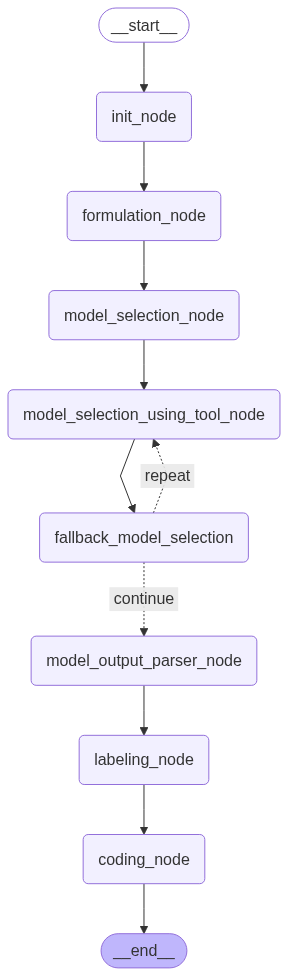

In [180]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

### testing

In [181]:
df_task

,STT,Task,Validation data
0,1,"""Bối cảnh của vấn đề:\r\nNhận dạng chữ viết ta...",Link
1,2,Bối cảnh của vấn đề:\r\nTrong thời đại thông t...,Link
2,3,Bối cảnh của vấn đề:\r\nĐây là một nhiệm vụ hồ...,Link
3,4,Bối cảnh của vấn đề:\r\nĐiều quan trọng là các...,Link
4,5,Bối cảnh của vấn đề:\r\nTrong nhiều ứng dụng t...,Link
5,6,🐾 Story: Alice’s Magical Pet Photo Box\r\nAlic...,Link


In [182]:
task_no = 5
task = df_task["Task"][task_no]

In [183]:
state = app.invoke({"task": task})

/tmp/ipykernel_54192/7332665.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  desc = str(row[1]).replace("{", "{{").replace("}", "}}")
/tmp/ipykernel_54192/7332665.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  url = str(row[2])




> Entering new AgentExecutor chain...

Invoking: `web_scrapper` with `{'url': 'https://huggingface.co/wesleyacheng/dog-breeds-multiclass-image-classification-with-vit'}`



Model made by notebook first posted in my Kaggle.
Model Motivation
Recently, someone asked me if you can classify dog images into their respective dog breeds instead just differentiating from cats vs dogs like my last notebook. I say YES!
Due to the complexity of the problem, we will be using the most advanced computer vision architecture released in the 2020 Google paper, the Vision Transformer.
The difference between the Vision Transformer and the traditional Convolutional Neural Network (CNN) is how it treats an image. In Vision Transformers, we take the input as a patch of the original image, say 16 x 16, and feed in into the Transformer as a sequence with positional embeddings and self-attention, while in the Convolutional Neural Network (CNN), we use the same patch of original image as an input, but use conv

## Model Selected

In [184]:
ans = state['model_detailed_list']
for i in range(len(ans.models)):
    print(f"Model {i}:")
    pprint.pprint(ans.models[i].model_description)
    pprint.pprint(ans.models[i].model_input_format)
    pprint.pprint(ans.models[i].model_output_format)
    pprint.pprint(ans.models[i].model_requirements)
    pprint.pprint(ans.models[i].model_sample_code)

Model 0:
('This model is finetuned using the Google Vision Transformer '
 '(vit-base-patch16-224-in21k) on the Stanford Dogs dataset in Kaggle to '
 'classify dog images into120 types of dog breeds.')
'Input: Dog image. Expected input format: Image file.'
('Output: Predicted dog breed. The model predicts one of the 120 Stanford dog '
 'breeds classes.')
'transformers, PIL, requests'
('from transformers import AutoImageProcessor, '
 'AutoModelForImageClassification\n'
 'import PIL\n'
 'import requests\n'
 '\n'
 'url = "https://upload.wikimedia.org/wikipedia/commons/5/55/Beagle_600.jpg"\n'
 'image = PIL.Image.open(requests.get(url, stream=True).raw)\n'
 'image_processor = '
 'AutoImageProcessor.from_pretrained("wesleyacheng/dog-breeds-multiclass-image-classification-with-vit")\n'
 'model = '
 'AutoModelForImageClassification.from_pretrained("wesleyacheng/dog-breeds-multiclass-image-classification-with-vit")\n'
 'inputs = image_processor(images=image, return_tensors="pt")\n'
 'outputs = m

## Code Generation

In [185]:
print(state['code'])

```python
import os
import csv
from tqdm import tqdm
from PIL import Image
import torch
from transformers import AutoImageProcessor, AutoModelForImageClassification

# Load models for dog breed classification
dog_model_name = "wesleyacheng/dog-breeds-multiclass-image-classification-with-vit"
dog_processor = AutoImageProcessor.from_pretrained(dog_model_name)
dog_model = AutoModelForImageClassification.from_pretrained(dog_model_name)

# Load models for cat emotion classification
cat_model_name = "google/vit-base-patch16-224-in21k"
# Since we only have placeholder sample code, assuming a custom fine-tuned model is used
# for cat emotion classification; replace 'path_or_model_name' with actual model path if available.
# For this example, assuming same base model with a fine-tuned head.
cat_processor = AutoImageProcessor.from_pretrained(cat_model_name)
# Note: The exact fine-tuned model for cat emotion should be loaded here.
# For demonstration, we'll re-use the same base model (not realist